# SynthDet Evaluation

This notebook is for the model prediction visualization. You can load your models, trained on synthetic datasets generated from the [SynthDet](https://github.com/Unity-Technologies/synthdet) example project, and visualize predicted bounding boxes for the GroceriesReal dataset. Also, this notebook can analyze the easy and hard cases from the point of view of the model. This would provide a better understanding about how to minimize sim2real gaps or improve model performance.<br>
You can use this notebook by the following steps:
- Specify checkpoint file GCS path. Then, the notebook would load the checkpoints into `FasterRCNN` estimator. `FasterRCNN` can provide model predictions. 
- Can either specify or randomly select some cases for the visualization. 
- This notebook would analyze high precision, high recall, low precision, low recall cases for the loaded model.
- You can visualize sim2sim prediction results.

In [2]:
import os
import warnings

from PIL import ImageColor
from tensorboardX import SummaryWriter
from torchvision import transforms
from yacs.config import CfgNode as CN
import numpy as np
import pandas as pd
import plotly.express as px
import torch

from datasetinsights.datasets.unity_perception import Downloader, download_manifest
from datasetinsights.datasets import GroceriesReal, SynDetection2D
from datasetinsights.estimators import Estimator
from datasetinsights.estimators import FasterRCNN, convert_bboxes2canonical
from datasetinsights.evaluation_metrics.confusion_matrix import prediction_records, precision_recall
from datasetinsights.io import EstimatorCheckpoint, KubeflowPipelineWriter
from datasetinsights.stats import grid_plot, plot_bboxes, histogram_plot

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)

ImportError: cannot import name 'Downloader' from 'datasetinsights.datasets.unity_perception' (/Users/bowen.li/Documents/dataset-insights/datasetinsights/datasets/unity_perception/__init__.py)

## You settings
Specify your settings down below

In [2]:
# local data root to save downloaded dataset and model:
data_root = "/Users/bowen.li/data"
# TODO: move all the models into public bucket and rename those model paths.
# Synthetic
# Real-world
# Synthetic-And-Real-World-76-images

# Synthetic-trained or Fine-tuned model:
# Synth-trained model on 400K SynthDet dataset
# SYNTH_ESTIMATOR_CLOUD_PATH = "gs://thea-dev/runs/Train_90kmWnN/FasterRCNN.ep2.estimator"
# Fine-tuned model (pre-trained on 400K Synthetic data and fine-tuned on 76 images)
# SYNTH_ESTIMATOR_CLOUD_PATH = "gs://thea-dev/runs/20200805-2032/FasterRCNN.ep23.estimator"
# Fine-tuned model (pre-trained on 400K Synthetic data and fine-tuned on 380 images)
# SYNTH_ESTIMATOR_CLOUD_PATH = "gs://thea-dev/runs/20200629-1113/FasterRCNN.ep8.estimator"
# Fine-tuned model (pre-trained on 400K Synthetic data and fine-tuned on 760 images)
SYNTH_ESTIMATOR_CLOUD_PATH = "gs://thea-dev/runs/20200615-1751/FasterRCNN.ep7.estimator"

# Real-trained model on 760 images
REAL_ESTIMATOR_CLOUD_PATH = "gs://thea-dev/runs/faster_rcnn_groceries_v3_20200416_160133/FasterRCNN.ep83.estimator"
# Top/Bottom K images to show according to precision/recall score
K = 5

## Load data
Load GrocereisReal data (Validation data)

In [ ]:
# use python code to download the data.
!python -m datasetinsights.scripts.public_download --name=GroceriesReal

In [3]:
real_data = GroceriesReal(
    data_root=data_root,
    split="val",
    version="v3",
    transforms=FasterRCNN.get_transform()
)
print("Length of Groceries Real data:", len(real_data))

Length of Groceries Real data: 253


## Load Model

In [ ]:
if torch.cuda.is_available():
    print("Using cuda")
    device = torch.device("cuda")
else:
    print("Using cpu")
    device = torch.device("cpu")

In [4]:
# TODO: make sure it's working
def load_estimator(checkpoint):
    system = CN()
    system.distributed = False

    ap_args = CN()
    ap_args.iou_threshold = 0.5
    ap_args.interpolation = "NPointInterpolatedAP"
    ap = CN()
    ap.name = "AveragePrecision"
    ap.args = ap_args

    ar_args = CN()
    ar_args.iou_threshold = 0.5
    ar_args.max_detections = 100
    ar = CN()
    ar.name = "AverageRecall"
    ar.args = ar_args

    metrics = CN()
    metrics.AP = ap
    metrics.AR = ar

    config = CN()
    config.pretrained = False
    config.backbone = "resnet50"
    config.num_classes = 64
    config.checkpoint_file = checkpoint
    config.estimator = "FasterRCNN"
    config.pretrained_backbone = True
    config.system = system
    config.metrics = metrics

    writer = SummaryWriter()
    checkpointer = EstimatorCheckpoint(estimator_name=config.estimator, log_dir=writer.logdir, distributed=system.distributed)
    kfp_writer = KubeflowPipelineWriter()
    estimator = Estimator.create(config.estimator, config=config, writer=writer, kfp_writer=kfp_writer, device=device, checkpointer=checkpointer)
    
    return estimator

synth_estimator = load_estimator(SYNTH_ESTIMATOR_CLOUD_PATH)
real_estimator = load_estimator(REAL_ESTIMATOR_CLOUD_PATH)

Using cpu


## SIM2REAL Test

Use estimators train on SynthDet dataset and predict on GroceriesReal Dataset, we use this test to:<br>
- identify/visualize sim2real gaps.
- analyze easy and hard cases from the point of view of the model.<br>
<br>We highlight predicted bounding boxes into 2 colors: Green and Red.<br>
<font color='green'>Green boxes</font>: it's a correct predicted label and overlap the true box enough (overlap >= 0.5). <br>
<font color='red'>Red boxes</font>: it's a wrong prediction.<br>

In [5]:
label_mappings = pd.DataFrame(real_data.label_mappings.items(), columns=["Label ID", "Label Name"])

In [6]:
def prediction(synth_estimator, dataset, device, iou_thresh=0.5, box_score_thresh=0.5, real_estimator=None, index=None):
    """ model prediction.

    Args:
        synth_estimator (FasterRCNN): sim2real model.
        dataset: Dataset for prediction.
        device: model training on device (cpu|cuda)
        iou_thresh (float): iou threshold. Defaults to 0.5.
        box_score_thresh (float): box score threshold for filter out lower score bounding boxes. Defaults to 0.5.
        real_estimator (FasterRCNN): real2real model. Defaults to None.
        index (int): image index used for prediction. Defaults to None.

    Returns:
        a list of annotations.
    """
    if index is None:
        index = random.randint(0, len(dataset) - 1)
        print("Data index: ", index)
    pil_img, annotation = dataset[index]
    annotation = convert_bboxes2canonical([annotation])[0]
    img = transforms.ToPILImage()(pil_img).convert("RGB")
    
    synth_predict_annotation = synth_estimator.predict(pil_img, box_score_thresh=box_score_thresh)
    if real_estimator:
        real_predict_annotation = real_estimator.predict(pil_img, box_score_thresh=box_score_thresh)
        return img, annotation, synth_predict_annotation, real_predict_annotation
    else:
        return img, annotation, synth_predict_annotation

In [7]:
COLOR_MAPPING = ("red", "green")
def render_color_boxes(image, annotation, predict_annotation, font_size=100, box_line_width=15):
    """ render color for each box in one image.

    Args:
        image (PIL Image): the image for rendering.
        annotation (list[BBox2D]): ground truth annotation.
        predict_annotation (list[BBox2D]): predicted annotation.
        line_width (float): line width of the bounding boxes. Defaults to 10.
        font_scale (int): how many chars can be filled in the image horizontally. Defaults to 50.

    Returns:
        a rendered image.
    """
    pred_infos = prediction_records(annotation, predict_annotation)
    colors = [COLOR_MAPPING[rec] for score, rec in pred_infos]
    pred_img = plot_bboxes(
        image,
        predict_annotation,
        label_mappings,
        colors=colors,
        font_size=font_size,
        box_line_width=box_line_width,
    )
    return pred_img

In [8]:
def visualize_predictions(image_indicies):
    """ visualize predictions for SynthDet model (or real2real model).

    Args:
        image_indicies (list[int]): image indices for the visualization.

    """
    for i in image_indicies:
        img, annotation, synth_pred_ann, real_pred_ann = prediction(
            synth_estimator,
            real_data,
            device,
            iou_thresh=0.5,
            real_estimator=real_estimator,
            index=i,
        )
        gt_img = plot_bboxes(img, annotation, label_mappings, font_size=100, box_line_width=15)
        synth_pred_img = render_color_boxes(img, annotation, synth_pred_ann, font_size=100, box_line_width=15)
        real_pred_img = render_color_boxes(img, annotation, real_pred_ann, font_size=100, box_line_width=15)
        titles = [
            f"ground truth bounding boxes for Img {i + 1}",
            f"sim2real prediction for Img {i + 1}",
            f"ground truth bounding boxes for Img {i + 1}",
            f"real2real prediction for Img {i + 1}",
        ]
        grid_plot([[gt_img, synth_pred_img], [gt_img, real_pred_img]], figsize=(8, 10), img_type="rgb", titles=titles)

<b>Plot description</b><br>
For each image, there are four plots: <br>
- The first row is the ground truth(left) and sim2real model prediction(right). <br>
- The second row is the ground truth(left) and real2real model prediction(right).  <br>

### Predictions for some user-selected cases

For bounding box visualization, You can specify some cases or randomly select K cases.

In [9]:
# specify image_indicies if you want to visualize a particular set of images
# image_indicies = [0, 1, 2]
image_indicies = np.random.randint(low=0, high=len(real_data), size=K)

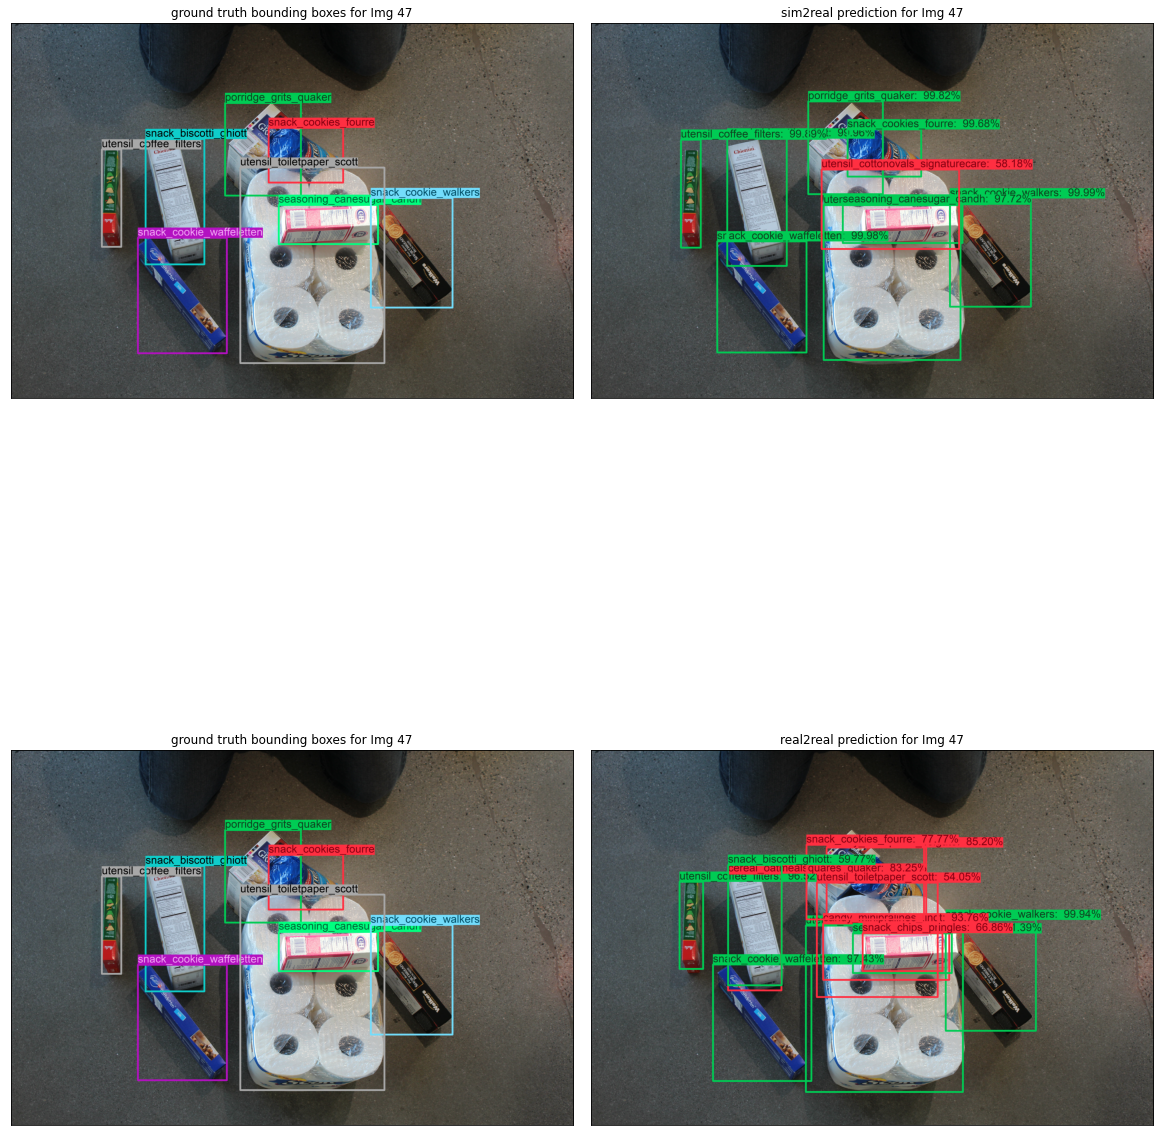

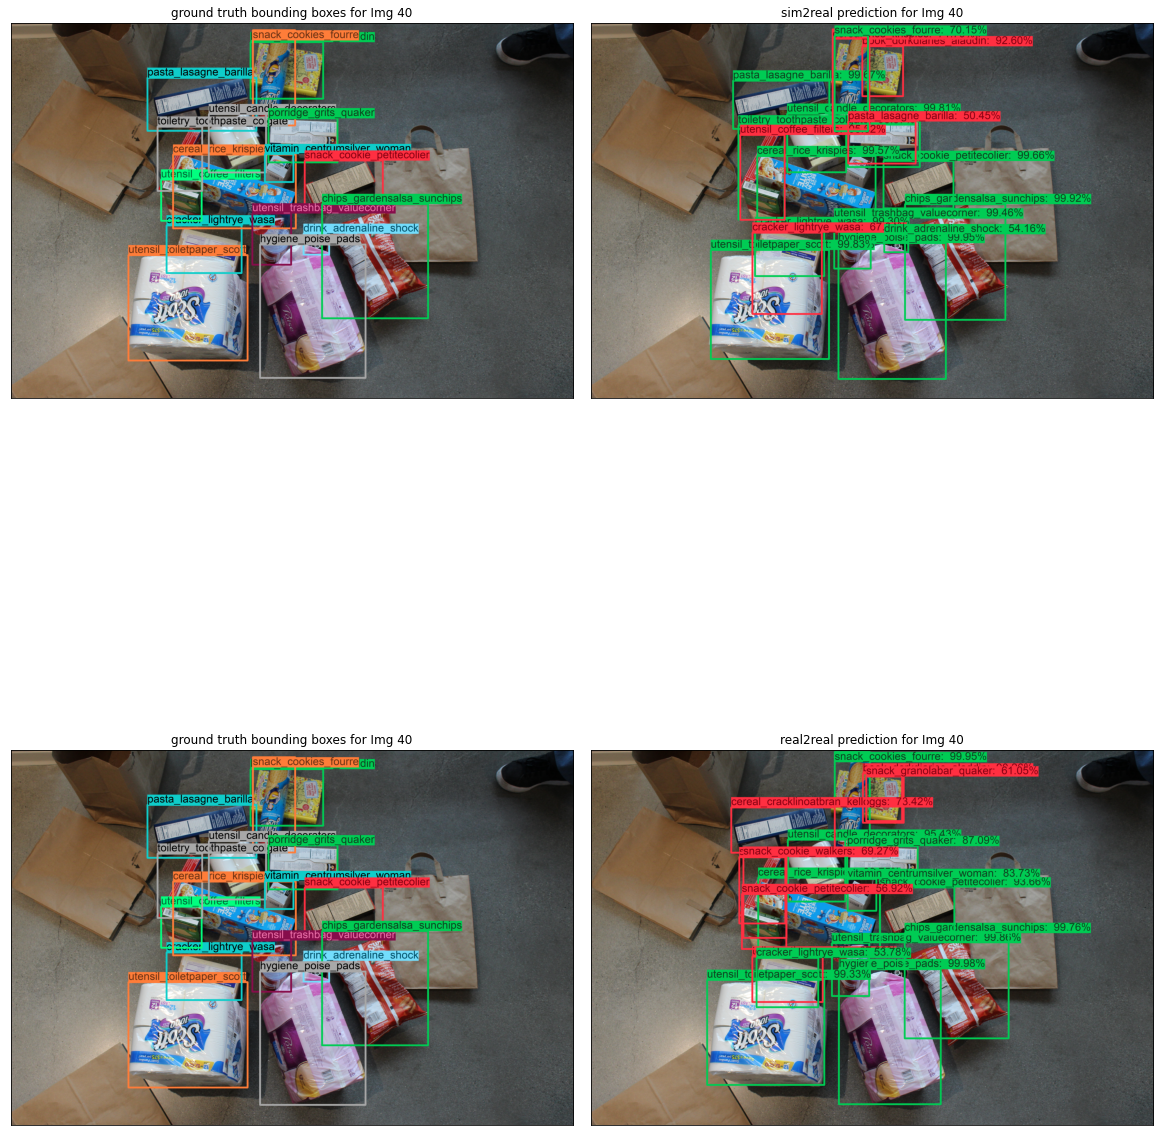

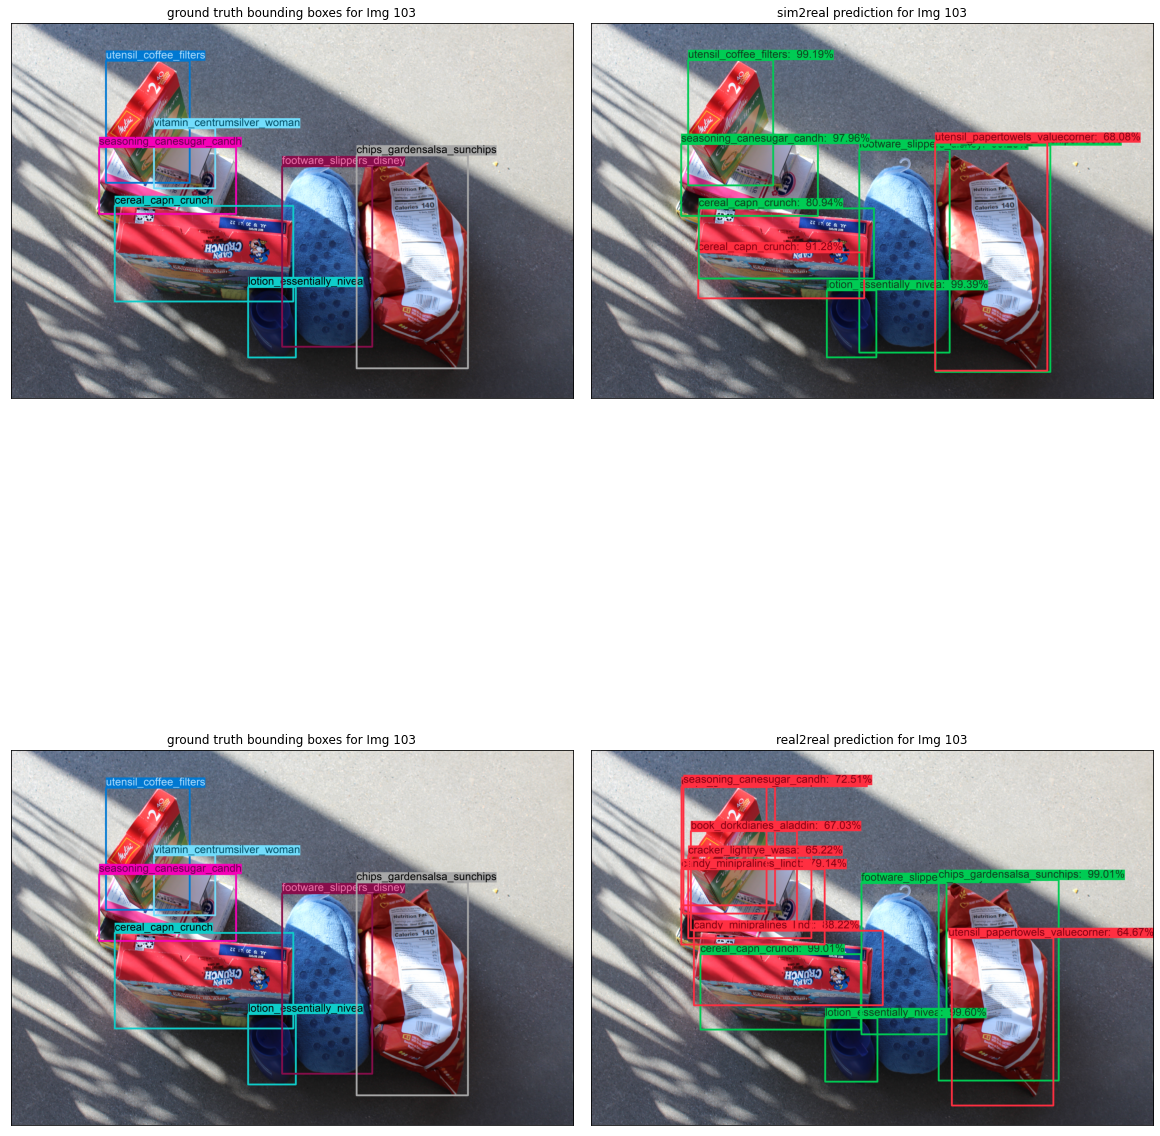

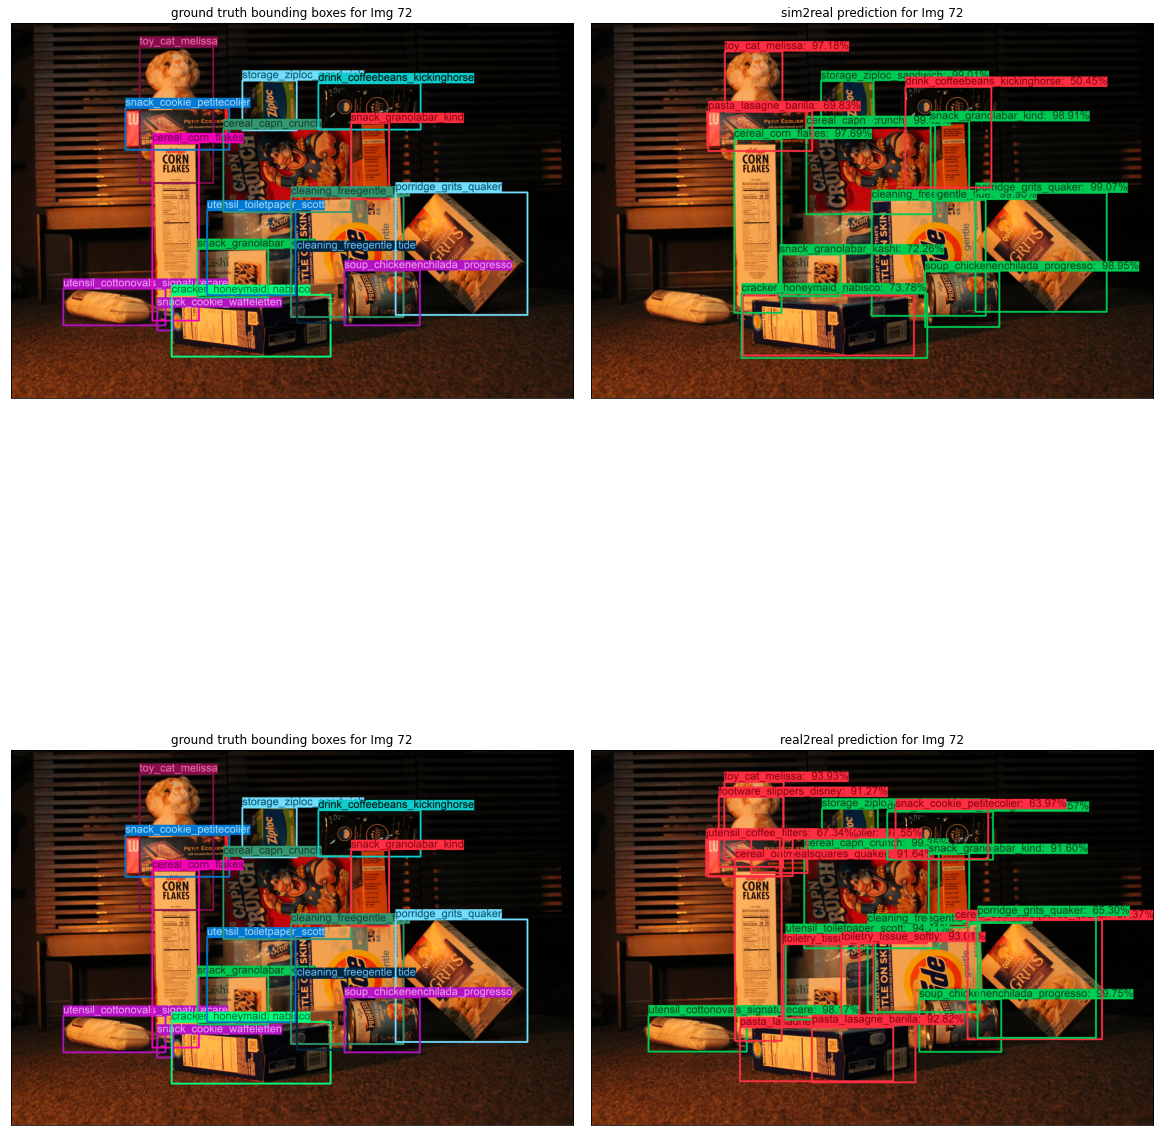

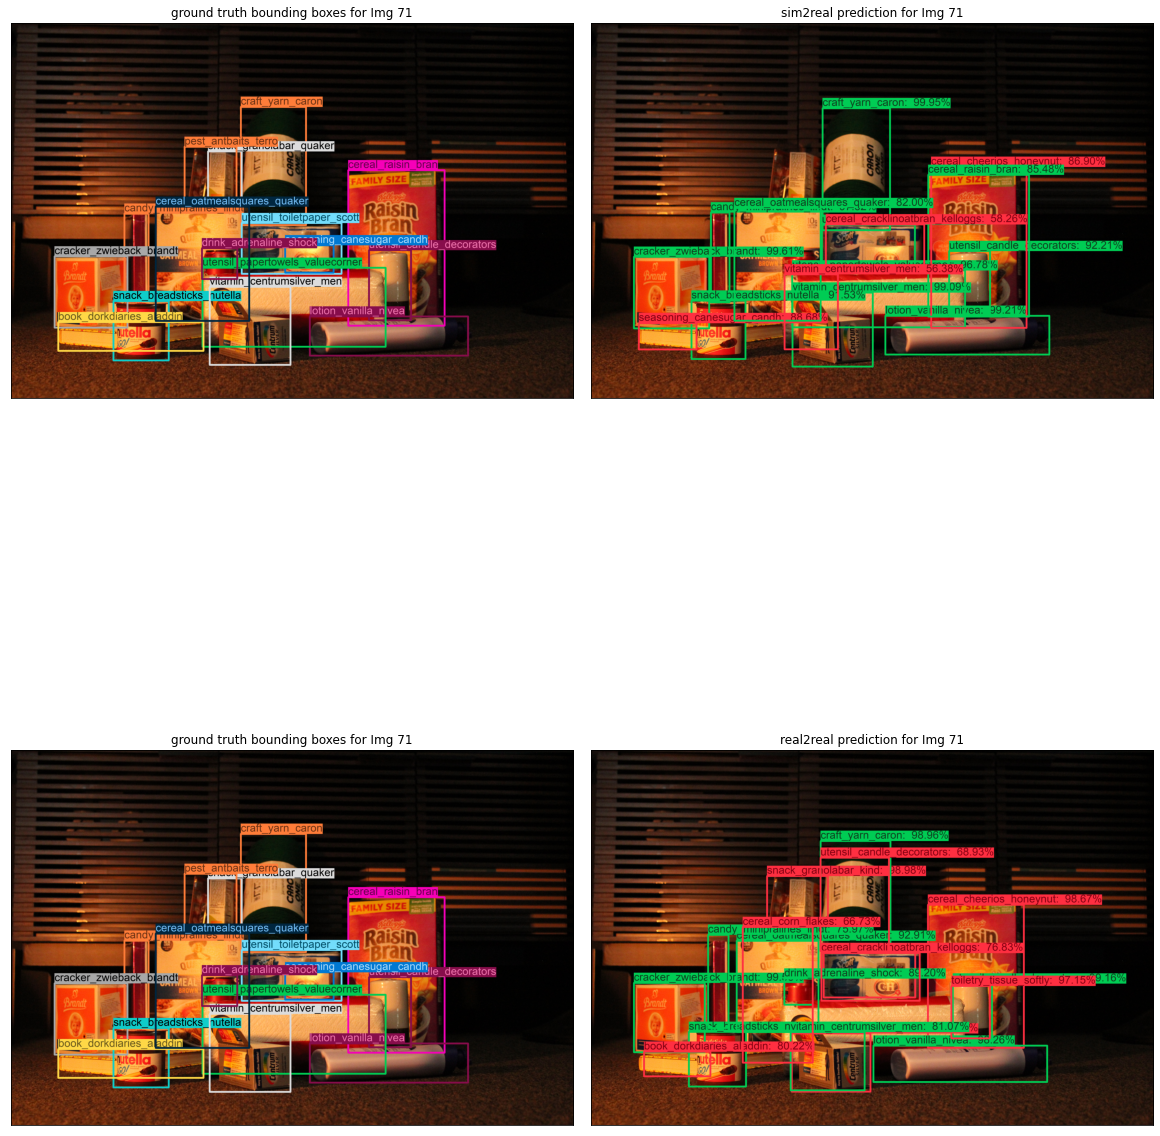

In [10]:
visualize_predictions(image_indicies)

### Visualization by precision/recall (Optional)

This would take lots of time to run.
We compute the prediction per image according to precision/recall. Here we define the precision/recall per image as follows:

-  precision per image = TP / (TP + FP).
-  recall per image = TP / (TP + FN). 

Here True Positive (TP) are defined as the the bounding boxes with IOU > threshold. We choose threshold = 0.5.
This preidcition is class agnostic. It's computed per image.


###  Per image precision and recall distribution

In [11]:
def calculate_all_pr(
    model,
    dataset,
    rate_records,
    iou_thresh=0.5,
):
    
    """ calculate precision and recall for all images.
        
    Args:
        model (FasterRCNN): a faster_rcnn model.
        dataset: Dataset for prediction.
        iou_thresh (float): iou threshold. Defaults to 0.5.
        rate_records (pandas.DataFrame): prediction records. It has three columns, id, precision, recall

    """
    for i in range(len(real_data)):
        pil_img, annotation = dataset[i]
        annotation = convert_bboxes2canonical([annotation])[0]
        predict_annotation = model.predict(pil_img, box_score_thresh=0.5)
        ap, ar = precision_recall(annotation, predict_annotation, iou_thresh)
        rate_records.loc[len(rate_records)] = [i, ap, ar]

In [12]:
# calculate precison recall for all images and all prediction
rate_records = pd.DataFrame({
    "id": pd.Series([], dtype="int"),
    "precision": pd.Series([], dtype="float"),
    "recall": pd.Series([], dtype="float")
})
calculate_all_pr(synth_estimator, real_data, rate_records, iou_thresh=0.5)
rate_records["id"] = rate_records["id"].astype(int)

KeyboardInterrupt: 

In [ ]:
histogram_plot(
    rate_records, 
    x="precision",  
    x_title="precision",
    y_title="Frequency",
    title=f"per image precision dostribution",
)

In [ ]:
histogram_plot(
    rate_records, 
    x="recall",  
    x_title="Recall per image",
    y_title="Frequency",
    title=f"Histogram of recall per image for {len(rate_records)} images",
)

### The following section visualize four cases 

We pick K images from the following regions:

- [High Precision](#high_precision)
- [High Recall](#high_recall)
- [Low Precision](#low_precision)
- [Low Recall](#low_recall) 


<a id='high_precision'></a>
#### High Precision

In [ ]:
precision_easy_cases = rate_records.nlargest(K, "precision")
precision_easy_cases

In [ ]:
visualize_predictions(precision_easy_cases["id"])

<a id='high_recall'></a>
#### High Recall

In [ ]:
recall_easy_cases = rate_records.nlargest(K, 'recall')
recall_easy_cases

In [ ]:
visualize_predictions(recall_easy_cases["id"])

<a id='low_precision'></a>
#### Low Precision

In [ ]:
precision_hard_cases = rate_records.nsmallest(K, 'precision')
precision_hard_cases

In [ ]:
visualize_predictions(precision_hard_cases["id"])

<a id='low_recall'></a>
#### Low Recall

In [ ]:
recall_hard_cases = rate_records.nsmallest(K, 'recall')
recall_hard_cases

In [ ]:
visualize_predictions(recall_hard_cases["id"])

## SIM2SIM Predictions

Use Synthetic-trained model to predict Synthetic data. Randomly select K Synthetic images. For each image, there are two plots:

- The ground truth(left). <br>
- The sim2real model prediction(right). <br>

This section requires to download the Synthetic dataset. Please make sure you have enough disk. If you're downloading data using Unity Simulations you can get auth_token by following this [tutorial](https://github.com/Unity-Technologies/Unity-Simulation-Docs/blob/master/doc/quickstart.md). If you want to use public SynthDet dataset follow SynthDet Data Download cells below.

### Unity Simulation [Optional]
Download Synthetic data

In [ ]:
# run execution id:
# run_execution_id = "xxx"
# auth token:
# auth_token = "xxx"
# annotation definition id:
# annotation_definition_id = "6716c783-1c0e-44ae-b1b5-7f068454b66e"
# unity project id
# project_id = "xxx"

In [ ]:
# manifest_file = os.path.join(data_root, "synthetic", f"{run_execution_id}.csv")
# download_manifest(run_execution_id, manifest_file, auth_token, project_id)
# dl = Downloader(manifest_file, data_root, use_cache=True)
# dl.download_references()
# dl.download_binary_files()

### SynthDet Data Download [Optional]
If you haven't used USim to donwload data, alternatively you can download public synthdet dataset which consists of around 5k synthetic images.

In [ ]:
from datasetinsights.datasets.synthetic import SynDetection2D
SynDetection2D.download(data_root, "v1")
annotation_definition_id = "c31620e3-55ff-4af6-ae86-884aa0daa9b2"

Load Synthetic data.

In [ ]:
synth_data = SynDetection2D(
    data_root=os.path.join(data_root),
    def_id=annotation_definition_id,
    transforms=FasterRCNN.get_transform()
)
print("Length of Synth data:", len(synth_data))

You can specify some cases or randomly select K cases.

In [ ]:
# specify image_indicies if you want to visualize a particular set of images
# synth_image_indicies = [0, 1, 2]
synth_image_indicies = np.random.randint(low=0, high=len(synth_data), size=K)

In [ ]:
for i in synth_image_indicies:
    img, annotation, synth_pred_ann = prediction(
        synth_estimator,
        synth_data,
        device,
        iou_thresh=0.5,
        index=i,
    )
    gt_img = plot_bboxes(img, annotation, label_mappings, box_line_width=2, font_size=100)
    synth_pred_img = render_color_boxes(img, annotation, synth_pred_ann, line_width=2)
    titles = [
        f"ground truth bounding boxes for Img {i + 1}",
        f"sim2sim prediction for Img {i + 1}",
    ]
    grid_plot([[gt_img, synth_pred_img]], figsize=(10, 10), img_type="rgb", titles=titles)